In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from constants import *

We read in the data, but we treat video durations and publish dates of 0 as NaN since 0 length videos or videos published on YouTube in 1970 make no sense.

In [2]:
sb_data = pd.read_csv(sb_data_file, 
                      dtype=dtypes,
                      usecols=lambda col: col not in unwanted_cols,
                      #converters={'timeSubmitted':convert_timestamp_to_seconds},
                      skiprows=range(1, 6_000_000),
                      nrows = 2_000_000,
                      na_values={'videoDuration': [0],
                                 'published': [0]}
                     )

pd.set_option('display.max_columns', None)
display(sb_data.head())

,videoID,startTime,endTime,votes,locked,userID,timeSubmitted,views,category,actionType,videoDuration,hidden,reputation,shadowHidden,channelID,title,published,isVIP
0,leyogCcxEX4,125.19,129.519,0,False,1267d4383ea5e9e9add1dabead22c999d7d2f44aa8763a...,1.658317e+09,0,filler,skip,1796.0,2,0.0,False,UChLtXXpo4Ge1ReTEboVvTDg,Trump holds bilateral meeting with Australian ...,1.568938e+09,False
1,leyogCcxEX4,1719.74,1727.290,0,False,1267d4383ea5e9e9add1dabead22c999d7d2f44aa8763a...,1.658317e+09,0,filler,skip,1796.0,2,0.0,False,UChLtXXpo4Ge1ReTEboVvTDg,Trump holds bilateral meeting with Australian ...,1.568938e+09,False
2,leyogCcxEX4,1590.39,1599.760,0,False,1267d4383ea5e9e9add1dabead22c999d7d2f44aa8763a...,1.658317e+09,0,filler,skip,1796.0,2,0.0,False,UChLtXXpo4Ge1ReTEboVvTDg,Trump holds bilateral meeting with Australian ...,1.568938e+09,False
3,leyogCcxEX4,1778.46,1784.110,0,False,1267d4383ea5e9e9add1dabead22c999d7d2f44aa8763a...,1.658317e+09,0,filler,skip,1796.0,2,0.0,False,UChLtXXpo4Ge1ReTEboVvTDg,Trump holds bilateral meeting with Australian ...,1.568938e+09,False
4,leyogCcxEX4,587.30,593.500,0,False,1267d4383ea5e9e9add1dabead22c999d7d2f44aa8763a...,1.658317e+09,0,filler,skip,1796.0,2,0.0,False,UChLtXXpo4Ge1ReTEboVvTDg,Trump holds bilateral meeting with Australian ...,1.568938e+09,False


In [3]:
# investigate missing data
for col in sb_data:
    count = sb_data[col].isna().sum()
    if count:
        print(f"{col}: {count}")

videoDuration: 32463
reputation: 50
channelID: 174905
title: 174905
published: 365106


In [4]:
length = sb_data.shape[0]
print(f"sponsorTime: length {length}")
for col in sb_data:
    series = sb_data[col]
    if pd.api.types.is_numeric_dtype(series) or pd.api.types.is_bool_dtype(series):
        count = (series == 0).sum()
        if count/length >= 0:
            print(f"\t{col}: {count/length}")

sponsorTime: length 2000000
	startTime: 0.127475
	endTime: 0.004118
	votes: 0.9478085
	locked: 0.9733385
	timeSubmitted: 0.0
	views: 0.6317565
	videoDuration: 0.0
	hidden: 0.6992335
	reputation: 0.700421
	shadowHidden: 0.814703
	published: 0.0
	isVIP: 0.9776385


In [5]:
sb_data['category'].value_counts()

category
filler              996114
outro               235249
intro               234954
sponsor             234145
selfpromo            98082
interaction          91070
poi_highlight        52323
preview              25197
music_offtopic       25121
chapter               6597
exclusive_access      1148
Name: count, dtype: int64

In [6]:
pd.set_option('display.float_format', '{:.2f}'.format)
sb_data.describe()

,startTime,endTime,votes,timeSubmitted,views,videoDuration,hidden,reputation,published
count,2000000.00,2000000.00,2000000.00,2000000.00,2000000.00,1967537.00,2000000.00,1999950.00,1634894.00
mean,1679.74,1712.79,0.02,1660457224.25,141.50,3516.25,0.60,2.02,1596979235.28
std,3946.74,12000.63,0.52,2361189.11,2131.41,6606.75,0.91,5.57,85923962.72
min,0.00,0.00,-14.00,1658317481.52,0.00,1.12,0.00,-2.50,1131321600.00
25%,69.42,100.90,0.00,1658616832.64,0.00,526.48,0.00,0.00,1566950400.00
50%,407.84,433.75,0.00,1659466300.95,0.00,1214.96,0.00,0.00,1633219200.00
75%,1541.23,1565.02,0.00,1661390309.48,11.00,3607.00,2.00,2.19,1659484800.00
max,193237.94,16027781.00,119.00,1666958218.58,831329.00,165710.73,2.00,27.00,1666915200.00


From the above table we notice a few main issues to acount for later.

- Missing video durations: We need a way to resolve this whilst still having endTime be less than video duration for EVERY video.
    - One strategy to handle this is to check all videoIDs for the maximum endTime and then scaling with the median videoDuration/endTime ratio for that videoID.
    - Alternatively we can impute with ignore, but we'd like to scale startTime and endTime relative to the videoDuration.
- Missing published dates prevent us from calculated the difference between timeSubmitted and time published.
    - This can be easily resolved by calculated the difference and then imputing with the median.

# Feature Engineering

There are a few features that we believe will be useful.

- segmentDuration (endTime-startTime)
- scaledStart (startTime/videoDuration)
- scaledEnd (endTime/videoDuration)
- timeToSubmission (timeSubmitted - published)

In [7]:
sb_data['segmentDuration'] = sb_data['endTime']-sb_data['startTime']
sb_data['scaledStart'] = sb_data['startTime']/sb_data['videoDuration']
sb_data['scaledEnd'] = sb_data['endTime']/sb_data['videoDuration']
sb_data['scaledSegmentDuration'] = sb_data['segmentDuration']/sb_data['videoDuration']
sb_data['timeToSubmission'] = sb_data['timeSubmitted']-sb_data['published']
#sb_data['views_per_vote'] = sb_data['views']/sb_data['votes']

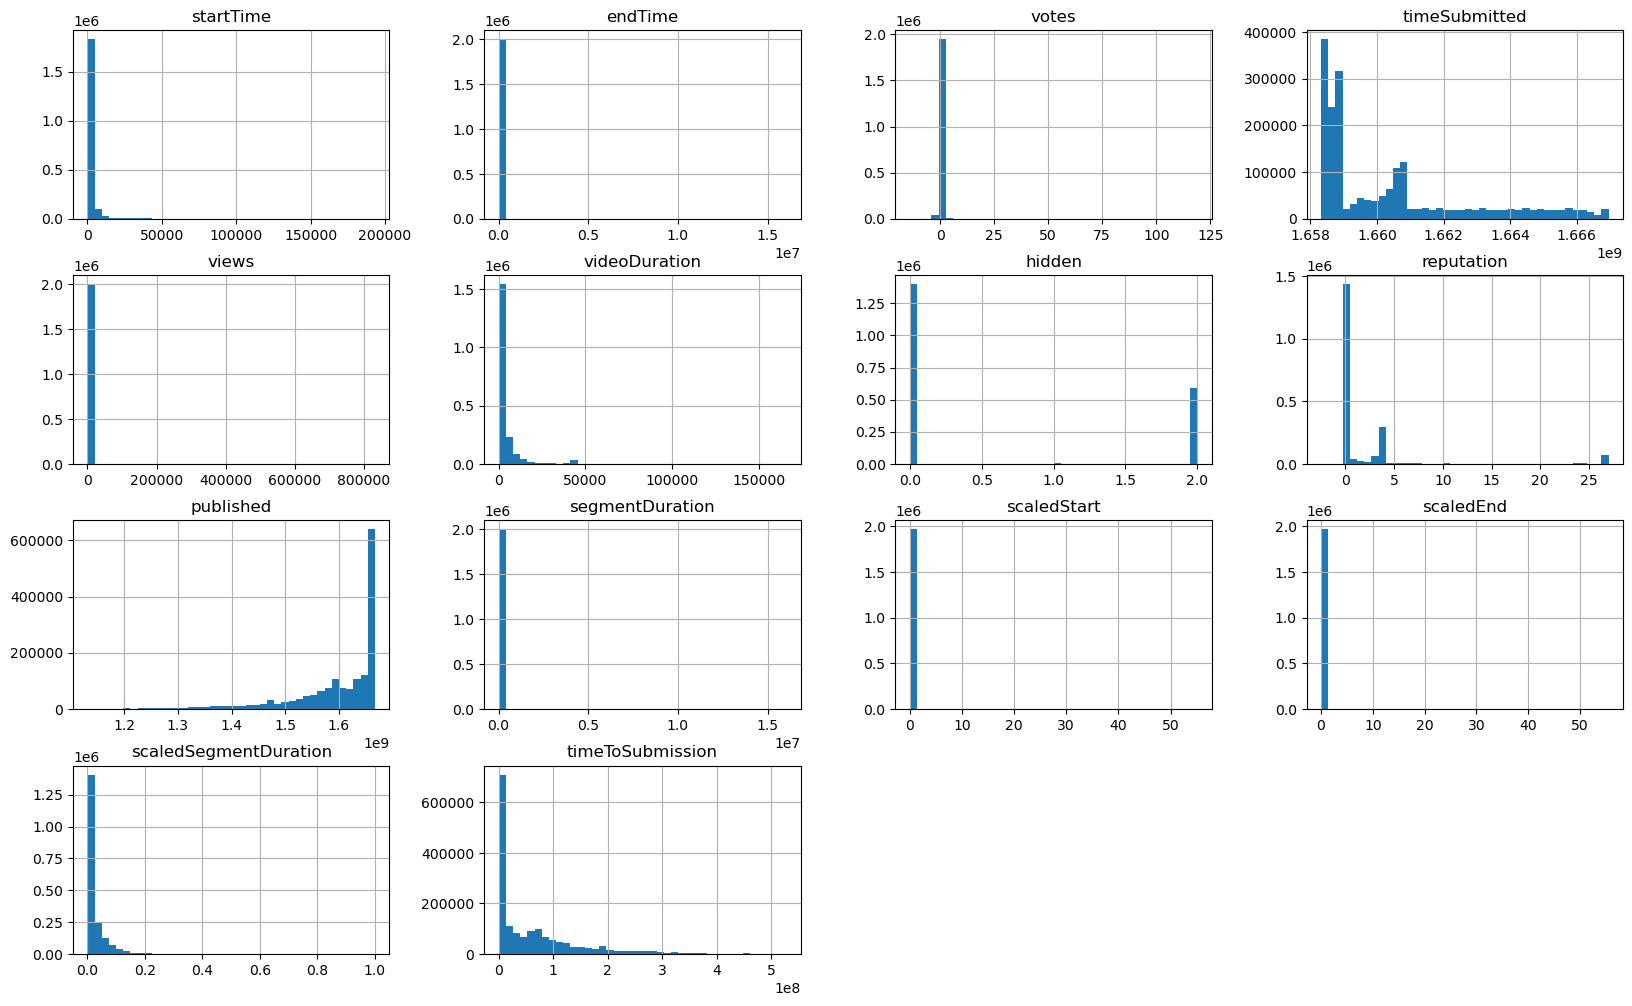

In [21]:
sb_data.hist(bins=40, figsize=(20,12))
plt.show()

The above graphs don't tell us much other than there are very significant outliers, so we should use standard scaler.

array([[<Axes: xlabel='timeSubmitted', ylabel='timeSubmitted'>,
        <Axes: xlabel='published', ylabel='timeSubmitted'>,
        <Axes: xlabel='timeToSubmission', ylabel='timeSubmitted'>,
        <Axes: xlabel='startTime', ylabel='timeSubmitted'>,
        <Axes: xlabel='endTime', ylabel='timeSubmitted'>,
        <Axes: xlabel='segmentDuration', ylabel='timeSubmitted'>,
        <Axes: xlabel='scaledStart', ylabel='timeSubmitted'>,
        <Axes: xlabel='scaledEnd', ylabel='timeSubmitted'>,
        <Axes: xlabel='scaledSegmentDuration', ylabel='timeSubmitted'>,
        <Axes: xlabel='videoDuration', ylabel='timeSubmitted'>,
        <Axes: xlabel='views', ylabel='timeSubmitted'>,
        <Axes: xlabel='reputation', ylabel='timeSubmitted'>,
        <Axes: xlabel='votes', ylabel='timeSubmitted'>],
       [<Axes: xlabel='timeSubmitted', ylabel='published'>,
        <Axes: xlabel='published', ylabel='published'>,
        <Axes: xlabel='timeToSubmission', ylabel='published'>,
        <Axes:

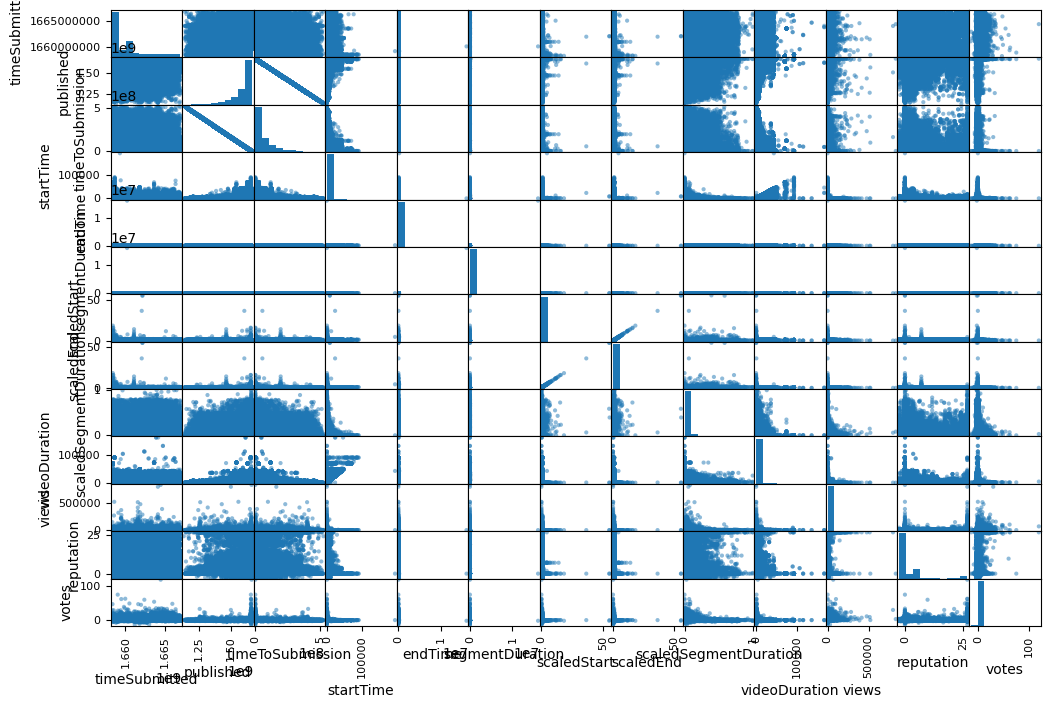

In [10]:
# DO NOT RUN THIS CELL. IT TAKES FOREVER
attributes = ["timeSubmitted", "published", "timeToSubmission", "startTime", "endTime", "segmentDuration", "scaledStart", "scaledEnd", "scaledSegmentDuration", "videoDuration", "views", "reputation", "votes"]
pd.plotting.scatter_matrix(sb_data[attributes], figsize=(12, 8))

In [45]:
from scipy.stats import f_oneway

categories = sb_data['category'].unique()
numerical_columns = ["timeSubmitted", "published", "timeToSubmission", "startTime", "endTime", "segmentDuration", "scaledStart", "scaledEnd", "scaledSegmentDuration", "videoDuration", "views", "reputation", "votes"]
boolean_like_columns = ['hidden', 'shadowHidden', 'locked', 'isVIP']
# Group numerical data by categories
for num_col in numerical_columns+boolean_like_columns:
    df_clean = sb_data.dropna(subset=['category', num_col])
    groups = (df_clean[df_clean['category'] == category][num_col] 
              for category in categories)
    # Perform ANOVA
    f_stat, p_value = f_oneway(*groups)
    print(num_col)
    print(f"\tF-statistic: {f_stat}, p-value: {p_value}")

timeSubmitted
	F-statistic: 82247.55530079664, p-value: 0.0
published
	F-statistic: 7722.452402462916, p-value: 0.0
timeToSubmission
	F-statistic: 7349.398329763225, p-value: 0.0
startTime
	F-statistic: 16638.407093440437, p-value: 0.0
endTime
	F-statistic: 1620.6046832659995, p-value: 0.0
segmentDuration
	F-statistic: 2.500673543853773, p-value: 0.005332954323397943
scaledStart
	F-statistic: 131681.96404266916, p-value: 0.0
scaledEnd
	F-statistic: 129904.89694919669, p-value: 0.0
scaledSegmentDuration
	F-statistic: 41288.83335766454, p-value: 0.0
videoDuration
	F-statistic: 18343.73225145363, p-value: 0.0
views
	F-statistic: 2950.1107430690267, p-value: 0.0
reputation
	F-statistic: 9434.955340196386, p-value: 0.0
votes
	F-statistic: 1484.9795849184309, p-value: 0.0
hidden
	F-statistic: 143820.79900888464, p-value: 0.0
shadowHidden
	F-statistic: 15237.420269418582, p-value: 0.0
locked
	F-statistic: 6852.983880562269, p-value: 0.0
isVIP
	F-statistic: 8115.877182354497, p-value: 0.0


In [67]:
encoded = pd.get_dummies(sb_data['category'])

# Combine with numerical data
combined = pd.concat([sb_data[numerical_columns+boolean_like_columns], encoded], axis=1)

# Correlation matrix
correlation_matrix = combined.corr()

def highlight_correlations(val, threshold=0.1, cap=1):
    if val > threshold and val < cap:
        color = 'background-color: lightgreen'  # Positive correlation
    elif val < -threshold:
        color = 'background-color: lightcoral'  # Negative correlation
    else:
        color = ''
    return color

#display(correlation_matrix)
left_matrix = correlation_matrix.iloc[:,:17]
styled_left_matrix = left_matrix.style.map(highlight_correlations)
display(styled_left_matrix)

,timeSubmitted,published,timeToSubmission,startTime,endTime,segmentDuration,scaledStart,scaledEnd,scaledSegmentDuration,videoDuration,views,reputation,votes,hidden,shadowHidden,locked,isVIP
timeSubmitted,1.000000,0.288808,-0.270425,-0.165742,-0.053534,0.001032,-0.140607,-0.113924,0.205701,-0.159994,0.064886,0.226629,0.042883,-0.518410,0.005509,0.156344,0.132953
published,0.288808,1.000000,-0.999817,0.048727,0.050256,0.065161,-0.056728,-0.056577,-0.001756,0.074342,0.004341,0.176409,0.024330,-0.113721,0.154636,0.087374,0.068829
timeToSubmission,-0.270425,-0.999817,1.000000,-0.051897,-0.053384,-0.063411,0.054621,0.054944,0.005511,-0.077617,-0.003099,-0.172061,-0.023727,0.103508,-0.152147,-0.084909,-0.066599
startTime,-0.165742,0.048727,-0.051897,1.000000,0.328674,-0.000216,0.252001,0.226975,-0.187819,0.826445,-0.022796,-0.055709,-0.014454,0.254658,0.058334,-0.041318,-0.033848
endTime,-0.053534,0.050256,-0.053384,0.328674,1.000000,0.944373,0.250037,0.226072,-0.179483,0.827866,-0.007479,-0.018651,-0.007418,0.082594,0.018574,-0.013524,-0.010973
segmentDuration,0.001032,0.065161,-0.063411,-0.000216,0.944373,1.000000,-0.062079,-0.025959,0.283912,0.068327,0.000019,-0.000349,-0.002821,-0.001225,-0.000646,0.000068,0.000168
scaledStart,-0.140607,-0.056728,0.054621,0.252001,0.250037,-0.062079,1.000000,0.992027,-0.020736,0.007548,-0.034765,0.059079,-0.037966,0.076986,0.045861,-0.000548,-0.008236
scaledEnd,-0.113924,-0.056577,0.054944,0.226975,0.226072,-0.025959,0.992027,1.000000,0.105428,-0.019690,-0.031514,0.058987,-0.038867,0.047038,0.029018,0.001526,-0.006584
scaledSegmentDuration,0.205701,-0.001756,0.005511,-0.187819,-0.179483,0.283912,-0.020736,0.105428,1.000000,-0.215765,0.024312,0.001778,-0.008765,-0.234316,-0.131669,0.016427,0.012759
videoDuration,-0.159994,0.074342,-0.077617,0.826445,0.827866,0.068327,0.007548,-0.019690,-0.215765,1.000000,-0.021395,-0.071463,-0.011679,0.271722,0.059077,-0.034047,-0.015792


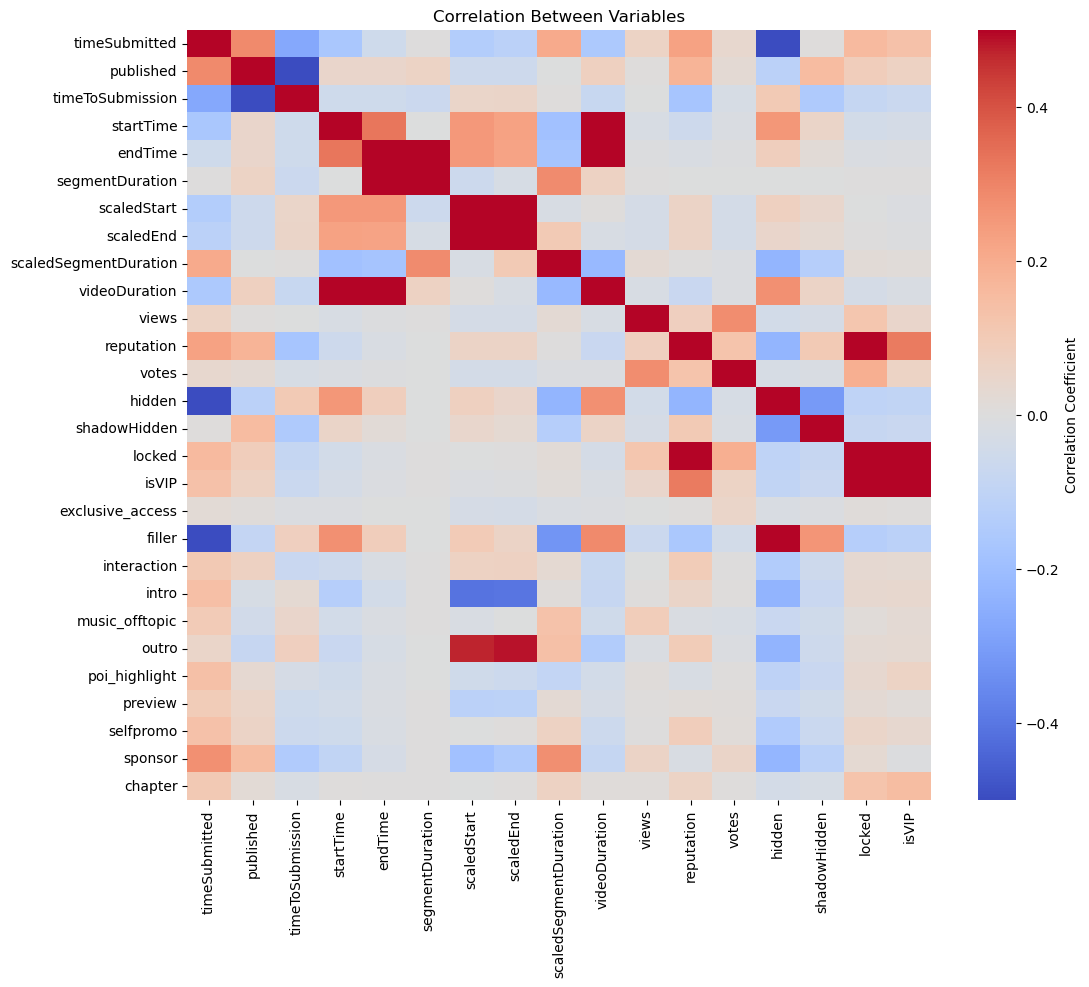

In [111]:
plt.figure(figsize=(12, 10))
sns.heatmap(left_matrix, cmap='coolwarm', vmin=-0.5, vmax=0.5, cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation Between Variables')
plt.show()

In [106]:
contingency_table = pd.crosstab(sb_data['actionType'],sb_data['category'])
normalized = contingency_table.div(contingency_table.sum(axis=0), axis=1)

# sns.heatmap(normalized, cmap='coolwarm', vmin=0, vmax=1)
# plt.title('Fraction of Action Type per Category')
# plt.show()

styled_table = normalized.style.map(lambda x: highlight_correlations(x,0.05,2))
display(styled_table)

category,exclusive_access,filler,interaction,intro,music_offtopic,outro,poi_highlight,preview,selfpromo,sponsor,chapter
actionType,,,,,,,,,,,
full,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.038886,0.013974,0.000000
mute,0.000000,0.000208,0.003722,0.000515,0.000080,0.000434,0.000000,0.001349,0.003242,0.001636,0.000000
poi,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
skip,0.000000,0.999792,0.996278,0.999485,0.999920,0.999566,0.000000,0.998651,0.957872,0.984390,0.000000
chapter,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


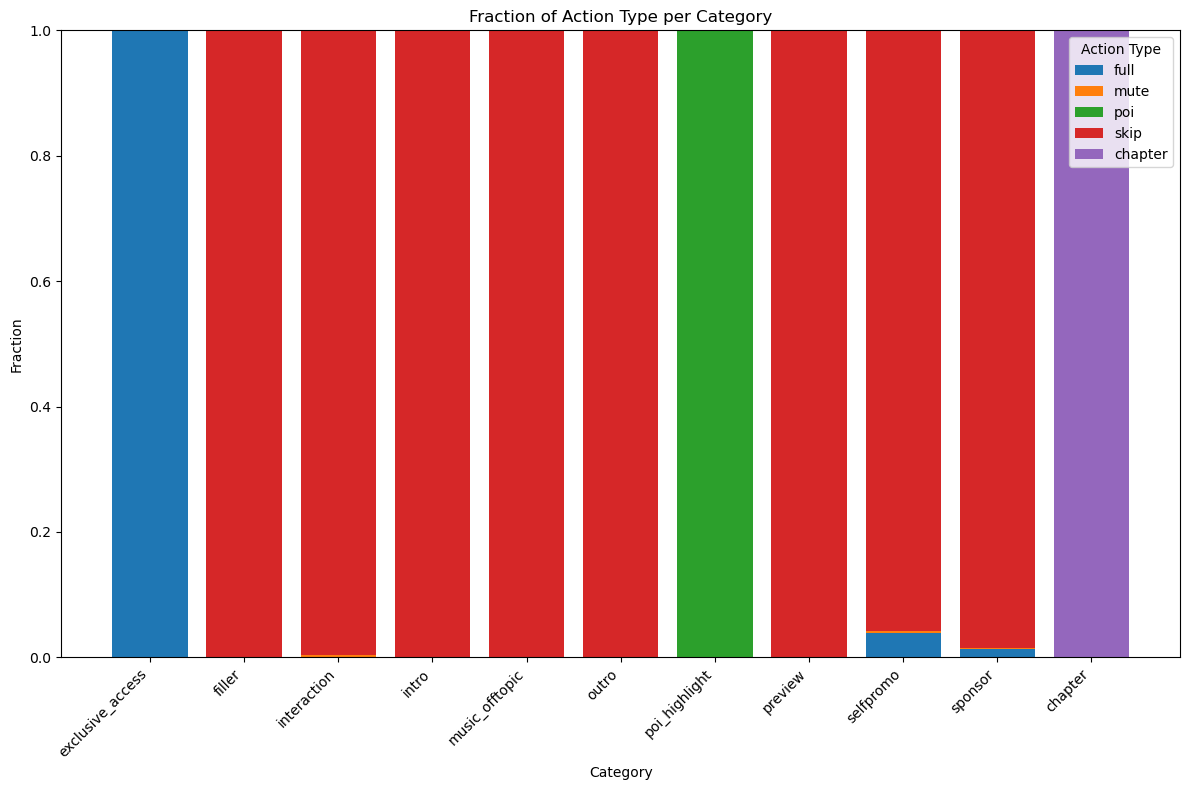

In [107]:
fig, ax = plt.subplots(figsize=(12, 8))

# Get categories and actions
categories = normalized.columns
actions = normalized.index

# Initialize the bottom of the bars at zero
bottoms = [0] * len(categories)

# Loop through each action type and plot it as a stack
for action in actions:
    ax.bar(categories, normalized.loc[action], bottom=bottoms, label=action)
    bottoms = [i + j for i, j in zip(bottoms, normalized.loc[action])]

# Add labels, legend, and rotate x-axis labels
ax.set_xlabel('Category')
ax.set_ylabel('Fraction')
ax.set_title('Fraction of Action Type per Category')
ax.legend(title='Action Type')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels properly
plt.tight_layout()

# Show the plot
plt.show()

In [65]:
from scipy import stats

chi2, _, _, _ = stats.chi2_contingency(contingency_table)

# Calculate Cramér's V
n = contingency_table.sum().sum()  # Total number of observations
min_dim = min(contingency_table.shape) - 1  # Degrees of freedom
cramers_v = np.sqrt(chi2 / (n * min_dim))

print(f"Cramér's V: {cramers_v}")

Cramér's V: 0.7349705793592116


C:\Users\TMOko\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
C:\Users\TMOko\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


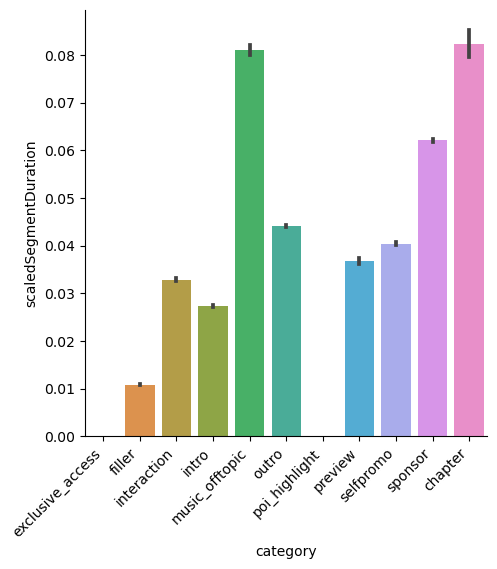

In [75]:
group_by = sb_data['actionType'].unique()

g = sns.catplot(data=sb_data, x='category', y='scaledSegmentDuration', kind='bar')
g.set_xticklabels(rotation=45, horizontalalignment='right')
plt.show()

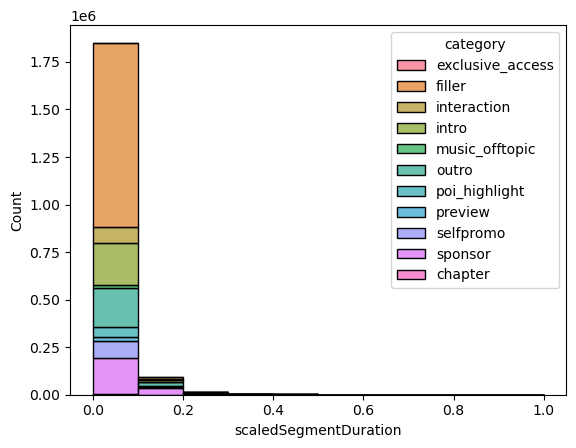

In [78]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

sns.histplot(
    data=sb_data,
    x='scaledSegmentDuration',
    hue='category',
    multiple='stack',  # Stacks the bars for different categories
    bins=10,           # Adjust number of bins as needed
    edgecolor='black'  # Optional: Add borders around bars
)
plt.show()

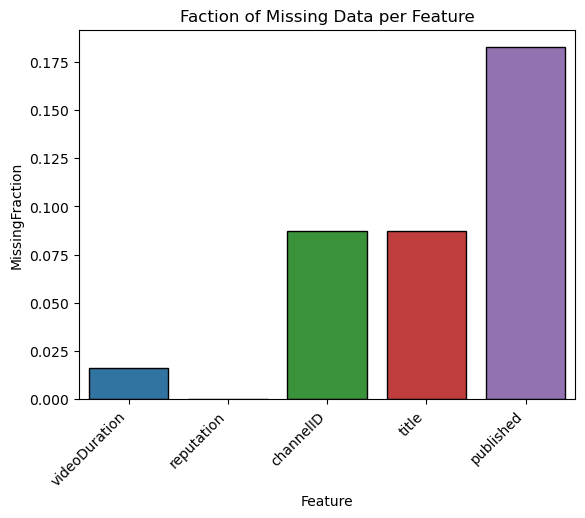

In [84]:
attributes_missing_data = ['videoDuration', 'reputation', 'channelID', 'title', 'published']
missing_fraction = sb_data[attributes_missing_data].isnull().mean()
missing_fraction = missing_fraction.reset_index()
missing_fraction.columns = ['Feature', 'MissingFraction']

p = sns.barplot(data=missing_fraction, x='Feature', y='MissingFraction', edgecolor='black')
p.set_xticklabels(missing_fraction['Feature'], rotation=45, horizontalalignment='right')
plt.title('Faction of Missing Data per Feature')
plt.show()